Image classification using Tensorflow.

To enable GPU usage (not used in this colab):
 1. Go to Edit -> Notebook settings
 2. For hardware accelerator select GPU

To get the requirements.txt file

## 1.1 Import libraries

In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib
# !pip install streamlit # App building
# !pip install pyngrok # cloud deployment

!pip install tensorflow opencv-python matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os, sys, requests # Folder structure / file path navigation
import cv2 # Image processing
import imghdr # Checking file extensions
import numpy as np # Pixel vectorization
import matplotlib.pyplot as plt # Image visualisation

# Unzipping tools
from zipfile import ZipFile
import tarfile

Next we will mount the Google drive and return the folders in the directory.

In [ ]:
# Mount Google drive
import io
from google.colab import files, drive
drive_path = drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# List the file contents
!ls -l /content/drive/MyDrive/Colab/TB_Detection/data

total 8
drwx------ 2 root root 4096 Jul  6 02:52 Normal
drwx------ 2 root root 4096 Jul  6 02:54 TB


The chest x-rays are divided between two folders; one for x-rays from patients with TB and one for those without TB.

In [ ]:
# Folders path
data_dir = '/content/drive/MyDrive/Colab/TB_Detection/data'
# List the folders in the path
os.listdir(data_dir)

['Normal', 'TB']

Next we will import images from and TB and non-TB chest x-rays.

First we will declare a list a of acceptable image extensions. Any image with the specified extensions will be removed.

In [ ]:
# Declare a list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

<class 'numpy.ndarray'>
(512, 512, 3)


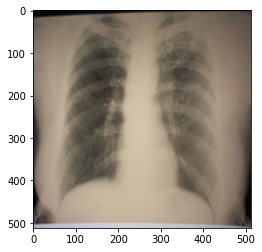

In [ ]:
# Import a test TB image along the specified path
tb_img = cv2.imread(os.path.join(data_dir,'TB', 'Tuberculosis-694.png'))
print(type(tb_img))
print(tb_img.shape)
plt.imshow(tb_img)
plt.show()

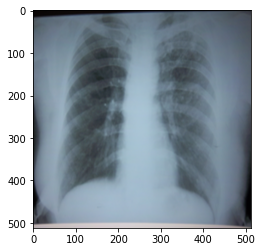

In [ ]:
# Convert the colours to plt's RGB requirement
plt.imshow(cv2.cvtColor(tb_img, cv2.COLOR_BGR2RGB))
plt.show()

<class 'numpy.ndarray'>
(512, 512, 3)


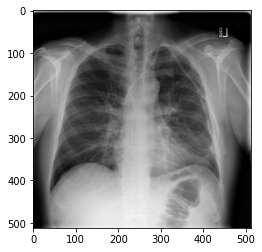

In [ ]:
# Import a test normal image
normal_img = cv2.imread(os.path.join(data_dir,'Normal', 'Normal-400.png'))
print(type(normal_img))
print(normal_img.shape)
plt.imshow(cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB))
plt.show()

Next we will loop through each folder and check the extension of every image. Any image with an extension not listed in `image_exts` will be removed.

In [ ]:
# Loop through each folder and delete non conforming extensions
for image_class in os.listdir(data_dir):
  # Loop through each subdirectory
  for image in os.listdir(os.path.join(data_dir, image_class)):
    # Loop through each image
    image_path = os.path.join(data_dir, image_class, image)
    try:
      # open the image
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      # Removing the image
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

Issue with image /content/drive/MyDrive/Colab/TB_Detection/data/TB/Mock image.gdoc


## 1.2 Load Data

Next we will build the image datasets using the data pipeline provided by Keras util API. This API does batch uploading (defaults to 32 per batch), which reduces memory usage. The API also performs a number of preprocessing steps including, image shuffling and image resizing (defaults to 256 x 256). 

This API produces a generator object.

In [ ]:
# Keras data pipeline helper to build image dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1969 files belonging to 2 classes.


Next we will create an iterator to access the batches in the generator.

Thereafter, we will retrieve one batch to inspect. Each batch is made up of two components; the actual image data and the labels.

In [ ]:
# Create data iterator to access generator from pipeline
data_iterator = data.as_numpy_iterator()

In [ ]:
#  Retrieve a batch at a time
batch = data_iterator.next()

In [ ]:
# Print the number of components in the batch
print(len(batch))

2


In [ ]:
# Images as numpy arrays
batch[0].shape

(32, 256, 256, 3)

The above is confirmation of the API reading in 32 images, 256 X 256 pixels in size, with 3 dimensions (one for colour).

The API automatically assigns the label (1 / 0).

In [ ]:
# Print batch labels 
batch[1]

array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0], dtype=int32)

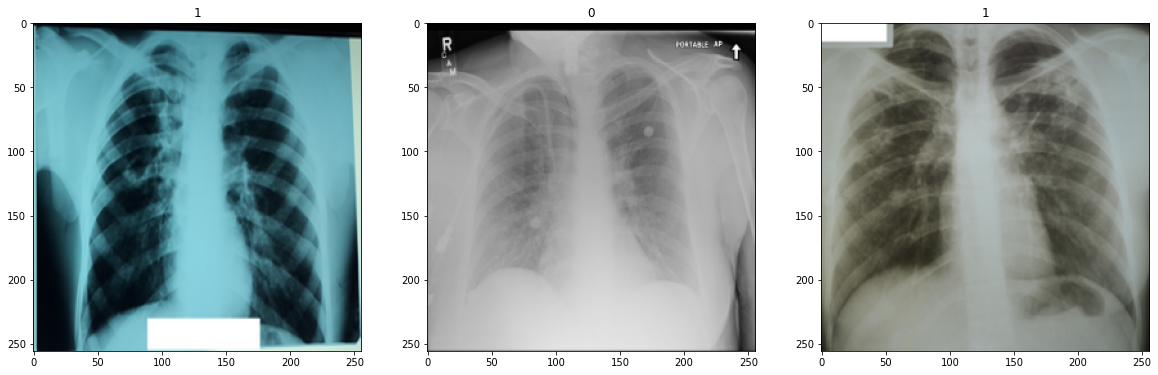

In [ ]:
# Check which label is assigned to which image
fig, ax = plt.subplots(ncols=3, figsize=(20,20))
for idx, img in enumerate(batch[0][0:3]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

Determined that:
* 1 == TB
* 0 == Normal

## 2 Pre-processing

### 2.1 Scale data
Next we will scale the image pixal (RGB) values which are between 0 and 255 to between 0 and 1 to ensure that the model generalises faster and produces more accurate results.

The scaling is performed in the pipeline using a lambda function.

In [ ]:
# Scale in the data pipeline
# x == features
# y == labels (no transformation on y)
scaled_data = data.map(lambda x,y: (x/255, y))

In [ ]:
# Iterating through the scaled data
scaled_iterator = scaled_data.as_numpy_iterator()

In [ ]:
# Retrieving batches of the scaled data
batch = scaled_iterator.next()

In [ ]:
# print the the min and max pixels to see scaling
print('Min pixal value:',batch[0].min())
print('Max pixal value:',batch[0].max())

Min pixal value: 0.0
Max pixal value: 1.0


In [ ]:
batch[1]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int32)

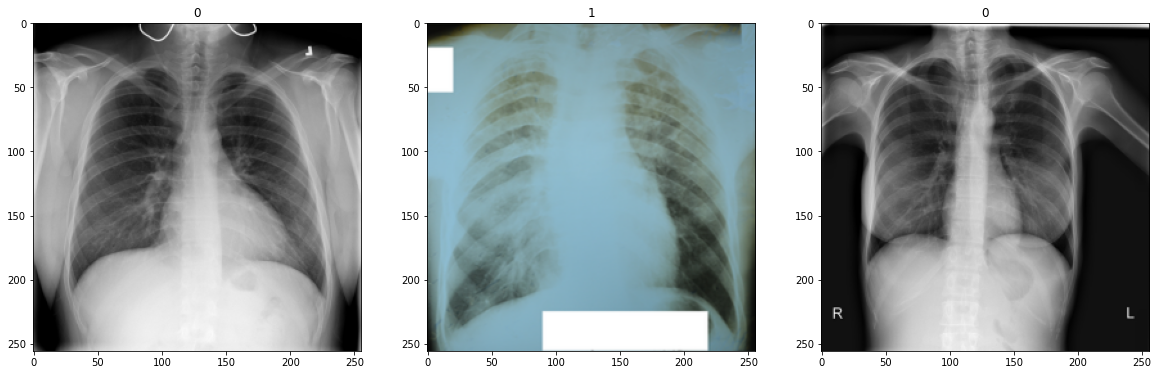

In [ ]:
# Check which label is assigned to which image
fig, ax = plt.subplots(ncols=3, figsize=(20,20))
for idx, img in enumerate(batch[0][0:3]):
  ax[idx].imshow(img.astype(float)) # Type float because it's scaled (divided by 255)
  ax[idx].title.set_text(batch[1][idx])

### 2.2 Split Data
Next we will split the data into; 
* Train (used to train the model),
* Validation (used to validate the model while training) 
* Test (used to the test the trained model).

Splitting the datasets ensures that we don't overfit. Splitting and allocating the data will be performed using the take and skip methods of the API.

Each batch has maximum 32 images.

In [ ]:
print('Number of batches:',len(data))

Number of batches: 62


In [ ]:
# Train and val used during training
# add explanation -- 
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1

In [ ]:
print('These are the assigned allocations')
print('Training batches:', train_size)
print('Validation batches:', val_size)
print('Test batches:', test_size)
print('Total:',train_size + val_size + test_size)

These are the assigned allocations
Training batches: 43
Validation batches: 12
Test batches: 7
Total: 62


In [ ]:
# Allocation of data (data must be shuffled before - ours has been)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
# Confirm allocations
print('These are the dataset allocations:')
print('Training batches:', len(train))
print('Validation batches:', len(val))
print('Test batches:', len(test))
print('Total:',len(train) + len(val) + len(test))


These are the dataset allocations:
Training batches: 43
Validation batches: 12
Test batches: 7
Total: 62


## 3. Deep Learning

## 3.1 Build Deep Learning Model

Next we will build a model using the Keras Sequential API. This is a way of creating deep learning models where an instance of the Sequential class is created and model layers are created and added to it. 

Best used for a plain stack of layers where each layer has one input tensor and one output tensor. I.e. it forms a cluster of a layer that is linearly stacked from top to bottom.

We will use the following layers:
* Convolutional layer (Conv2D) as the main building block. We will apply 16 filters with 3x3 pixel size.
* MaxPooling layer (MaxPooling2D) which condenses the images (along their height and width) by returning the maximum value per region (size determined by pool_size). The region is shifted by strides along each dimension.
* Flatten layer will reduce the multidimensional input into one-dimensional input that the Dense Layer is able to process.
* Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense. Dense Layer is used to classify image based on output from convolutional layers. 

The following activation functions are used:
* relu - to convert any output below zero to zero and it will preserve the positive values.
* sigmoid - converts any real value into another value between 0 and 1.

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [ ]:
# Instance of model object
model = Sequential()

In [ ]:
# First layer is a convelution with 16 filters which is 3x3 pixels size
# Stride of one, meaning it moves one pixel at a time.
# input is 256 pixels wide and pixels high and 3 channels deep
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Condenses the information (2x2) and returns the max value
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
# Get a single output (0 or 1)
model.add(Dense(1, activation='sigmoid'))


In [ ]:
# Compile the model - using adam optimiser
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 3.2 Train
Next we will train the model, log the model performance and save the logs to the directory, `logdir`, using a callback function.

The performance consists of the accuracy of the prediction as well as the loss (how far the predicted values deviate from the actual values) for the training data and the validation data.


In [ ]:
logdir = '/content/drive/MyDrive/Colab/TB_Detection/logs'
os.listdir(logdir)

['train', 'validation']

In [ ]:
# Save the logs from the models
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Fit the model
hist = model.fit(train, epochs=11 ,validation_data = val,callbacks = [tensorboard_callback])

Epoch 1/11
43/43 [==============================] - 96s 2s/step - loss: 21.2599 - accuracy: 0.7645 - val_loss: 0.6021 - val_accuracy: 0.8464
Epoch 2/11
43/43 [==============================] - 93s 2s/step - loss: 0.2796 - accuracy: 0.8990 - val_loss: 0.2253 - val_accuracy: 0.9271
Epoch 3/11
43/43 [==============================] - 93s 2s/step - loss: 0.1908 - accuracy: 0.9164 - val_loss: 0.2906 - val_accuracy: 0.9036
Epoch 4/11
43/43 [==============================] - 95s 2s/step - loss: 0.1399 - accuracy: 0.9462 - val_loss: 0.1901 - val_accuracy: 0.9401
Epoch 5/11
43/43 [==============================] - 93s 2s/step - loss: 0.0937 - accuracy: 0.9680 - val_loss: 0.2993 - val_accuracy: 0.9245
Epoch 6/11
43/43 [==============================] - 120s 3s/step - loss: 0.1010 - accuracy: 0.9702 - val_loss: 0.5446 - val_accuracy: 0.9036
Epoch 7/11
43/43 [==============================] - 93s 2s/step - loss: 0.1446 - accuracy: 0.9528 - val_loss: 0.2575 - val_accuracy: 0.9427
Epoch 8/11
43/43 [

## 3.3 Plot Performance




In [ ]:
# Print a list of the accuracy and loss
hist.history

{'accuracy': [0.7645348906517029,
  0.898982584476471,
  0.9164243936538696,
  0.9462209343910217,
  0.9680232405662537,
  0.9702034592628479,
  0.9527616500854492,
  0.9622092843055725,
  0.979651153087616,
  0.9920058250427246,
  0.9585756063461304],
 'loss': [21.25992202758789,
  0.27961596846580505,
  0.19081346690654755,
  0.13993602991104126,
  0.09370496869087219,
  0.10104396939277649,
  0.14458666741847992,
  0.09507104009389877,
  0.05734289065003395,
  0.028298484161496162,
  0.12413860112428665],
 'val_accuracy': [0.8463541865348816,
  0.9270833134651184,
  0.9036458134651184,
  0.9401041865348816,
  0.9244791865348816,
  0.9036458134651184,
  0.9427083134651184,
  0.9296875,
  0.9270833134651184,
  0.9322916865348816,
  0.9296875],
 'val_loss': [0.6021152138710022,
  0.22525207698345184,
  0.2906428277492523,
  0.1901082843542099,
  0.2992532253265381,
  0.5446277260780334,
  0.2575313150882721,
  0.45558884739875793,
  0.4222152531147003,
  0.4454987347126007,
  0.4219625

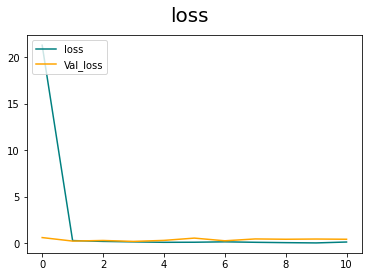

In [ ]:
#Visualise loss metrics
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='Val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

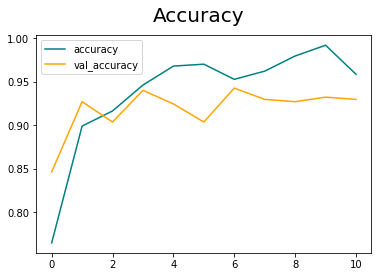

In [ ]:
#Visualise accuracy metrics
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## 4. Evaluate Performance

### 4.1 Evaluate

In [ ]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
# Instantiate metric objects
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:0.9285714030265808, Recall:0.9176470637321472,Accuracy:0.938025176525116


### 4.2 Test

In [ ]:
test_case_dir = '/content/drive/MyDrive/Colab/TB_Detection'
# Unseen normal image
img = cv2.imread(os.path.join(test_case_dir,'test_case', 'Normal-3500.png'))
# Resize the image
resize = tf.image.resize(img, (256,256))
# plt.imshow(resize.numpy().astype(int))
# Convert the colours from BGR to RBG
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Wrapping image in another set of arrays as expected by tf
# Run prediction
yhat = model.predict(np.expand_dims(resize/255, 0))
i = np.argmax(yhat[0])
yhat

array([[0.3551379]], dtype=float32)

In [ ]:
if yhat > 0.5:
  print(f'Predicted class is TB')
else:
  print(f'Predicted class is Normal')

Predicted class is Normal


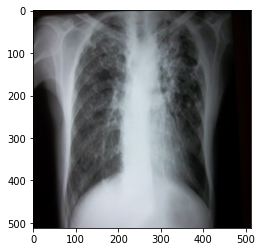

In [ ]:
# Unseen image
img = cv2.imread(os.path.join(test_case_dir,'test_case', 'Tuberculosis-700.png'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

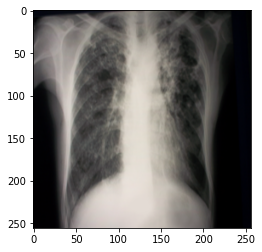

In [ ]:
# Resize the image
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
# Wrapping image in another set of arrays as expected by tf
# Run prediction
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

array([[0.97566986]], dtype=float32)

In [ ]:
if yhat > 0.5:
  print(f'Predicted class is TB')
else:
  print(f'Predicted class is Normal')

Predicted class is TB


## 5. Save the Model

### 5.1 Save the model

In [ ]:
from keras.models import load_model

In [ ]:
# Save the model
models_dir = '/content/drive/MyDrive/Colab/TB_Detection'
model.save(os.path.join(models_dir,'models', 'tb_detection_model.h5'))

In [ ]:
# Reload the model
new_model = load_model(os.path.join(models_dir,'models', 'tb_detection_model.h5'))

In [ ]:
# Confirm that the new model loaded
new_model

In [ ]:
# Image prediction with new_model
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.97566986]], dtype=float32)

## Generating a requirements file

In [ ]:
# !pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pipreqs

INFO: Successfully saved requirements file in /content/requirements.txt


In [ ]:
# # Generating a requirements file
# from pip._internal.utils.misc import get_installed_distributions

# def get_imported_packages():
#     p = get_installed_distributions()
#     p = {package.key:package.version for package in p}

#     imported_modules = set(sys.modules.keys())
    
#     imported_modules.remove('pip')

#     modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

#     return modules


# def generate_requirements(filepath:str, modules):
#     with open(filepath, 'w') as f:
#         for module, version in modules:
#             f.write(f"{module}=={version}\n")


# generate_requirements('requirements.txt', get_imported_packages())